In [1]:
from keras.preprocessing import image
from keras.layers import Input, Dense
from keras.models import Model

import matplotlib.pyplot as plt

import numpy as np
import os
import random

%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_DIR = "./data"
TRAIN_DIR = os.path.join(DATA_DIR, "train")


In [3]:
img = image.load_img('data/train/n01443537/images/n01443537_0.JPEG')

x = image.img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

In [4]:
x.shape

(1, 64, 64, 3)

In [5]:
#Model
from keras.models import Model
from keras.layers import *  

## Dataset creation
The dataset is composed of a random subset of images from all 200 classes.

In [6]:
def load_dataset(n_images_from_class_test=10):
    X_train = []
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c, 'images')
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        
        for img_name_i in c_imgs[0:n_images_from_class_test]:
            img_i = image.load_img(os.path.join(c_dir, img_name_i), target_size=(64, 64))
            x = image.img_to_array(img_i)
            X_train.append(x)

    return np.array(X_train)
    

In [7]:
X_train_orig = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.

print ("Number of training examples = " + str(X_train.shape[0]))
print ("X_train shape: " + str(X_train.shape))

Number of training examples = 2000
X_train shape: (2000, 64, 64, 3)


In [8]:
# S: secret image
input_S = X_train[0:X_train.shape[0] // 2]

# C: cover image
input_C = X_train[X_train.shape[0] // 2:]

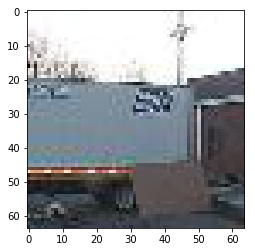

In [9]:
plt.imshow(X_train[11])

## Model

In [10]:
from keras.layers import concatenate, Conv2D

def create_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    
    # Prep network
    x = Conv2D(3, (7, 7), strides = (1, 1), padding = 'same', name = 'conv_prep')(input_S)
    
    x = concatenate([input_C, x])
    
    # Hiding network
    x = Conv2D(50, (3, 3), strides = (1, 1), padding = 'same', name = 'conv_hid0')(x)
    # x = MaxPooling2D((2, 2), padding='same', name = 'pool_hid0')(x)
    x = Conv2D(50, (4, 4), strides = (1, 1), padding = 'same', name = 'conv_hid1')(x)
    # x = MaxPooling2D((2, 2), padding='same', name = 'pool_hid1')(x)
    x = Conv2D(50, (4, 4), strides = (1, 1), padding = 'same', name = 'conv_hid2')(x)
    # x = MaxPooling2D((2, 2), padding='same', name = 'pool_hid2')(x)
    x = Conv2D(50, (5, 5), strides = (1, 1), padding = 'same', name = 'conv_hid3')(x)
    # x = MaxPooling2D((2, 2), padding='same', name = 'pool_hid3')(x)
    x = Conv2D(3, (5, 5), strides = (1, 1), padding = 'same', name = 'conv_hid4')(x)
    # output_Cprime = MaxPooling2D((2, 2), padding='same', name = 'c_prime')(x)
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding = 'same', name = 'conv_hid5')(x)
    
    # Reveal network
    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding = 'same', name = 'conv_rev0')(output_Cprime)
    # output_Sprime = MaxPooling2D((2, 2), padding='same', name = 's_prime')(x)
    
    # Models
    autoencoder = Model(inputs=[input_S, input_C], outputs=[output_Sprime, output_Cprime], name = "AutoEncoderModel")

    # encoder = Model(inputs=[input_S, input_C], outputs=output_Cprime)
    
    # encoded_input = Input(shape=(input_size))
    # decoder_c_layer = autoencoder.get_layer('c_prime')
    # decoder_s_layer = autoencoder.get_layer('s_prime')
    # decoder = Model(inputs=encoded_input, outputs=[decoder_s_layer(encoded_input), decoder_c_layer(encoded_input)])
        
    return autoencoder #, encoder, decoder

In [ ]:
autoencoder_model = create_model(input_S.shape[1:])

autoencoder_model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
autoencoder_model.fit([input_S, input_C], [input_S, input_C], epochs=10)

Epoch 1/10
1000/1000 [==============================] - 165s 165ms/step - loss: 0.8483 - conv_rev0_loss: 0.4460 - conv_hid5_loss: 0.4022
Epoch 2/10
1000/1000 [==============================] - 170s 170ms/step - loss: 0.2427 - conv_rev0_loss: 0.1378 - conv_hid5_loss: 0.1049
Epoch 3/10
1000/1000 [==============================] - 168s 168ms/step - loss: 0.1502 - conv_rev0_loss: 0.0804 - conv_hid5_loss: 0.0698
Epoch 4/10
 608/1000 [=================>............] - ETA: 1:05 - loss: 0.1091 - conv_rev0_loss: 0.0591 - conv_hid5_loss: 0.0500

## Results

In [ ]:
decoded = autoencoder_model.predict([input_S, input_C])

In [ ]:
decoded_S, decoded_C = decoded

n = 10
plt.figure(figsize=(8, 20))
for i in range(0, n):
    ax = plt.subplot(n,4, i * 4 + 1)
    plt.imshow(input_C[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(n,4, i * 4 + 2)
    plt.imshow(input_S[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(n, 4, i * 4 + 3)
    plt.imshow(decoded_C[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(n, 4, i * 4 + 4)
    plt.imshow(decoded_S[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()